In [1]:
%env TF_KERAS = 1
!pip install keras-rectified-adam

env: TF_KERAS=1


# Computing the Conditional Average Treatment Effect (CATE) with Neural Networks

In [0]:
import functools
import numpy as np
from scipy import stats
from scipy.special import expit

import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.backend as K

from keras_radam import RAdam

from IPython.display import SVG, Image

import seaborn as sns
import matplotlib.pyplot as graph
graph.style.use('fivethirtyeight')


def causal_regression_with_propensity_score(concat_true, concat_pred):
    """
    Currently an exact implementation of the paper, therefore NN

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    :return:
    """
    is_treatment_true = concat_pred[:, 3]

    is_treatment_pred = concat_pred[:, 2]
    propensity_score_entropy = K.mean(k.losses.binary_crossentropy(is_treatment_true, is_treatment_pred))

    y_true = concat_true[:, 0]
    y_pred_given_treatment = concat_pred[:, 0]
    y_pred_given_control = concat_pred[:, 1]

    treatment_mse = K.mean(is_treatment_true * K.square(y_true - y_pred_given_treatment))
    control_mse = K.mean((1-is_treatment_true) * K.square(y_true - y_pred_given_control))
    q = treatment_mse + control_mse

    return q + propensity_score_entropy


def conditional_average_treatment_effect(concat_true, concat_pred):
    """
    A metric for tracking the current estimate of the CATE where...

    CATE = [f(x|treatment) - f(x|control)].mean()

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    :return:
    """
    y_pred_given_treatment = concat_pred[:, 0]
    y_pred_given_control = concat_pred[:, 1]

    cate = K.mean(y_pred_given_treatment - y_pred_given_control)
    return cate


def propensity_xentropy(concat_true, concat_pred):
    """
    A metric for tracking how much progress the propensity score is making
    """
    return K.mean(k.losses.binary_crossentropy(
        concat_pred[:, 3],  # True is treatment 
        concat_pred[:, 2]   # Estimated propensity score
    ))


def treatment_accuracy(concat_true, concat_pred):
    return k.metrics.binary_accuracy(
        concat_pred[:, 3],  # True is treatment
        concat_pred[:, 2]   # Estimated propensity score
    )

$$CATE = {1 \over N} \sum [ f_{treatment}(x) - f_{control}(x) ] $$

$$J(\theta) = {1 \over N} \sum [ (f_{t_i}(x_i) - y_i)^2 + \mathcal{H}_{cross}(g(x_i), t_i) ] $$

By optimising $J(\theta)$ we are sure that we are optimising the CATE directly. This is both the model _must_ learn a covariate set in $Z$ that contains the information for estimating the propensity score. This should be _equivalent_ to adjusting for the propensity score.



In [3]:
# Setup quick fake data
n, p = int(1e4), 20
treatment_effect = 0.5

m = stats.norm().rvs(p)
x = stats.norm().rvs((n, p))
# treatment_labels = stats.bernoulli(0.2).rvs(n)  # Random assignment (Unconfounded)
treatment_labels = expit((x[:, :5] @ m[:5]) + 2*stats.norm().rvs(n)).round()  # Conditional assignment (Confounding)

y = x@m + treatment_effect*treatment_labels + stats.norm().rvs(n)

print(x.shape, y.shape, treatment_labels.shape)

(10000, 20) (10000,) (10000,)


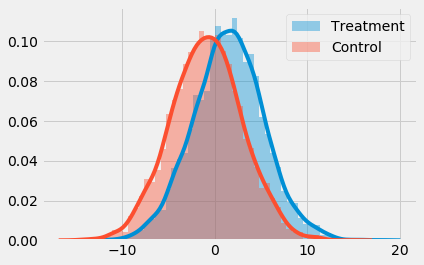

True Treatment Effect = 0.5
Naive Estimate of the Treatment Effect = 2.361030


In [4]:
# Naive Estimate
sns.distplot(y[treatment_labels.astype(bool)], label='Treatment')
sns.distplot(y[~treatment_labels.astype(bool)], label='Control')
graph.legend()
graph.show()

control_mean = y[~treatment_labels.astype(bool)].mean()
treatment_mean = y[treatment_labels.astype(bool)].mean()
naive_causal_estimate = treatment_mean - control_mean

print(f'True Treatment Effect = {treatment_effect}')
print(f'Naive Estimate of the Treatment Effect = {naive_causal_estimate:2f}')

W0829 17:38:23.005523 140240425592704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 75)           1575        X[0][0]                          
__________________________________________________________________________________________________
Z (Dense)                       (None, 25)           1900        dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 75)           1950        Z[0][0]                          
____________________________________________________________________________________________

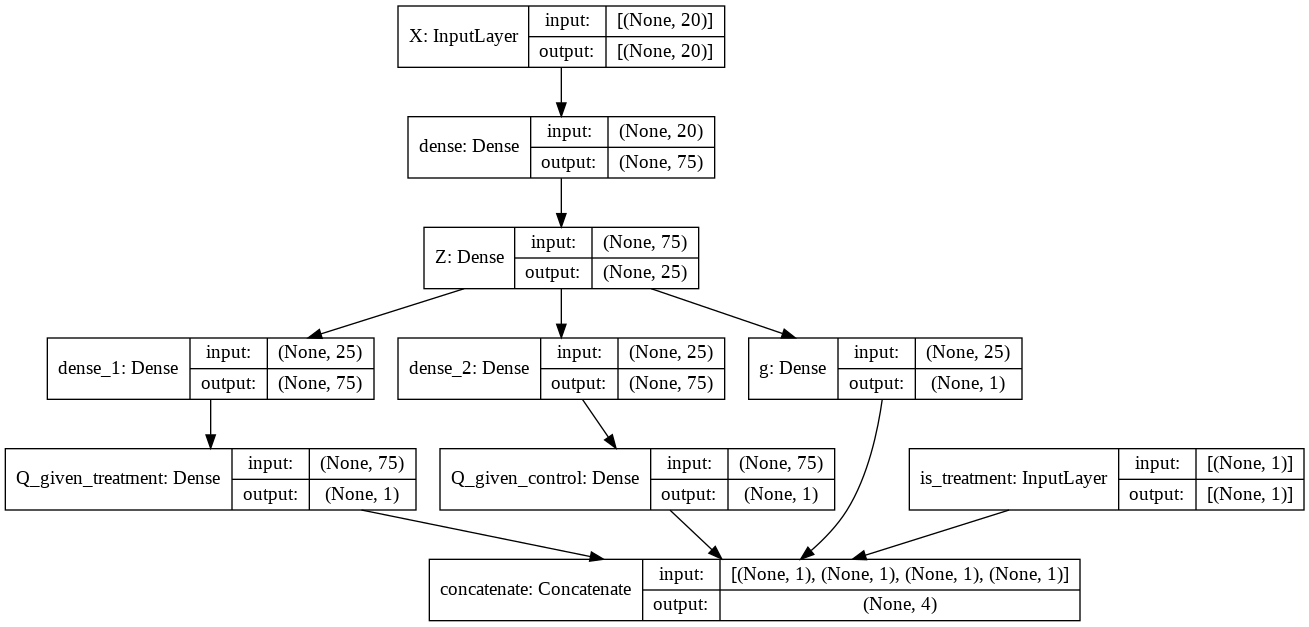

In [5]:
input_layer = k.layers.Input(shape=(x.shape[1],), name='X')
treatment_label_layer = k.layers.Input(shape=(1,), name='is_treatment')

# Compute Z
z = k.layers.Dense(75, activation='elu')(input_layer)
z = k.layers.Dense(25, activation='linear', name='Z')(z)

# Propensity estimator
g_hat = k.layers.Dense(1, activation='sigmoid', name='g')(z)

# Treatment Network
q_given_treatment = k.layers.Dense(75, activation='elu')(z)
q_given_treatment = k.layers.Dense(1, name='Q_given_treatment')(q_given_treatment)  # Set to the output dimensionality

# Control Network
q_given_control = k.layers.Dense(75, activation='elu')(z)
q_given_control = k.layers.Dense(1, name='Q_given_control')(q_given_control)

# Training output
concat_output = k.layers.concatenate([q_given_treatment, q_given_control, g_hat, treatment_label_layer])

treatment_model = k.models.Model(input_layer, q_given_treatment)
control_model = k.models.Model(input_layer, q_given_control)
propensity_model = k.models.Model(input_layer, g_hat)
trainable_model = k.models.Model([input_layer, treatment_label_layer], concat_output)

# Compile Models
print(trainable_model.summary())

k.utils.plot_model(trainable_model, to_file='tmp.png', show_shapes=True)
display(Image('tmp.png'))

trainable_model.compile(
    optimizer=RAdam(),#(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5), #k.optimizers.SGD(),
    loss=causal_regression_with_propensity_score,
    metrics=[conditional_average_treatment_effect, treatment_accuracy, propensity_xentropy]
)

In [6]:
hist = trainable_model.fit(
    [x, treatment_labels], y,
    epochs=10000, batch_size=len(x),
    validation_split=0.1,
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        k.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=True),
        k.callbacks.TerminateOnNaN(),
        k.callbacks.ModelCheckpoint('tmp.chk', monitor='val_loss', save_best_only=True)
    ],
    verbose=False
)

W0829 17:38:23.614234 140240425592704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


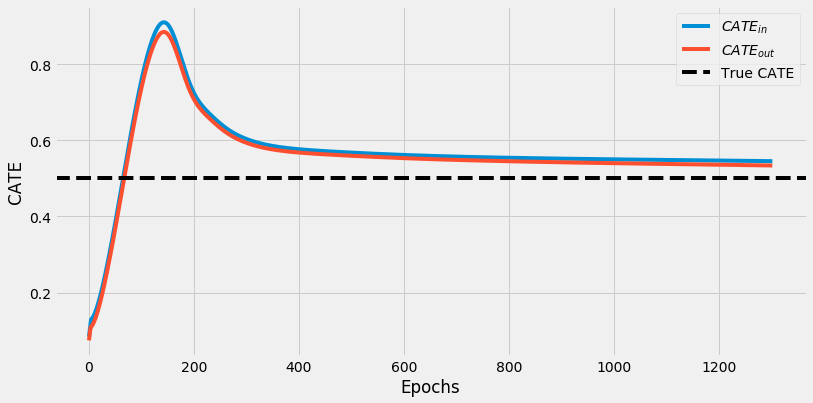

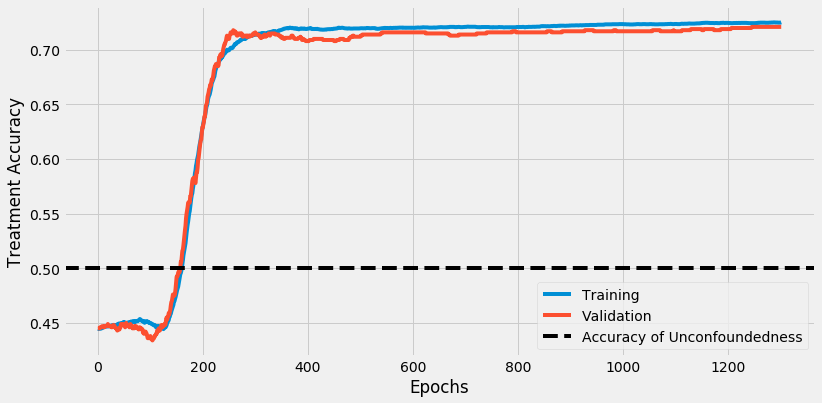

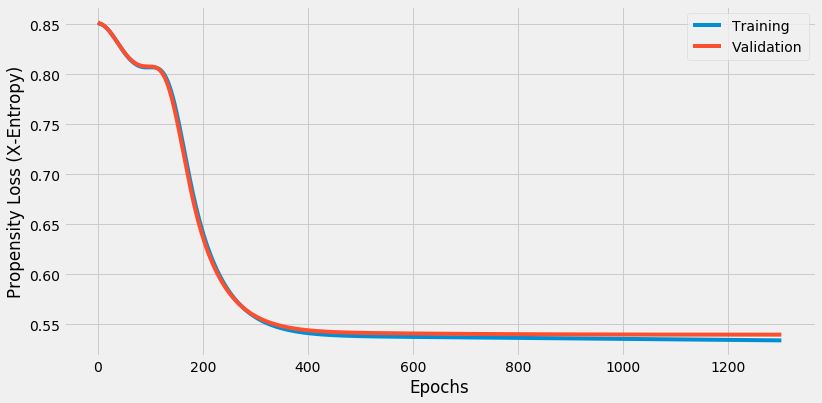

In [7]:
graph.figure(figsize=(12, 6))
graph.plot(hist.history['conditional_average_treatment_effect'], label=r'$CATE_{in}$')
graph.plot(hist.history['val_conditional_average_treatment_effect'], label=r'$CATE_{out}$')
graph.axhline(treatment_effect, linestyle='--', color='black', label='True CATE')
graph.ylabel('CATE')
graph.xlabel('Epochs')
graph.legend()
graph.show()

graph.figure(figsize=(12, 6))
graph.plot(hist.history['treatment_accuracy'], label='Training')
graph.plot(hist.history['val_treatment_accuracy'], label='Validation')
graph.axhline(
    max(treatment_labels.mean(), 1-treatment_labels.mean()), 
    linestyle='--', color='black', 
    label='Accuracy of Unconfoundedness'
)
graph.ylabel('Treatment Accuracy')
graph.xlabel('Epochs')
graph.legend()
graph.show()

graph.figure(figsize=(12, 6))
graph.plot(hist.history['propensity_xentropy'], label='Training')
graph.plot(hist.history['val_propensity_xentropy'], label='Validation')
graph.ylabel('Propensity Loss (X-Entropy)')
graph.xlabel('Epochs')
graph.legend()
graph.show()

In [0]:
squeeze = functools.partial(K.squeeze, axis=-1)


def create_conditional_average_treatment_effect(output_dim):
    def conditional_average_treatment_effect(_, concat_pred):
        """
        A metric for tracking the current estimate of the CATE where...

        CATE = [f(x|treatment) - f(x|control)].mean()

        :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
        :return:
        """
        y_pred_given_treatment = squeeze(concat_pred[:, :output_dim])
        y_pred_given_control = squeeze(concat_pred[:, output_dim:2*output_dim])

        cate = K.mean(y_pred_given_treatment - y_pred_given_control, axis=-1)
        return cate
    return conditional_average_treatment_effect


def propensity_xentropy(concat_true, concat_pred):
    """
    A metric for tracking how much progress the propensity score is making

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    """
    return K.mean(k.losses.binary_crossentropy(
        concat_pred[:, -1],  # True is treatment
        concat_pred[:, -2]   # Estimated propensity score
    ))


def treatment_accuracy(concat_true, concat_pred):
    """
    Accuracy about the propensity score

    :param concat_true: [y]
    :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
    :return:
    """
    return k.metrics.binary_accuracy(
        concat_pred[:, -1],  # True is treatment
        concat_pred[:, -2]   # Estimated propensity score
    )


def create_causal_regression_loss(output_dim):
    """
    Create a loss function specific to y dimensionality

    concat_true: [y]
    concat_pred: [y|treatment, y|control, propensity, is_treatment]

    :param output_dim:
    :return:
    """
    def causal_regression_with_propensity_score(concat_true, concat_pred):
        """
        Currently an exact implementation of the paper, therefore NN

        :param concat_true: [y]
        :param concat_pred: [y|treatment, y|control, propensity, is_treatment]
        :return:
        """
        is_treatment_true = concat_pred[:, -1]
        is_treatment_pred = concat_pred[:, -2]
        propensity_score_entropy = K.mean(k.losses.binary_crossentropy(is_treatment_true, is_treatment_pred))

        y_true = squeeze(concat_true[:, :output_dim])
        y_pred_given_treatment = squeeze(concat_pred[:, :output_dim])
        y_pred_given_control = squeeze(concat_pred[:, output_dim:2*output_dim])

        mse_treatment = K.mean(is_treatment_true * K.square(y_true - y_pred_given_treatment), axis=-1)
        mse_control = K.mean((1 - is_treatment_true) * K.square(y_true - y_pred_given_control), axis=-1)
        mse_given_treatment = mse_treatment + mse_control

        return mse_given_treatment + propensity_score_entropy

    return causal_regression_with_propensity_score


class JointCATEModel:
    def __init__(self,
                 x, y, treatment,
                 z_size=25,
                 epochs=10000, validation_split=0.1,
                 verbose=False, jupyter=False,
                 model_path='cate_model.nn'):
        self.z_size = z_size
        self.verbose = verbose
        self.model_path = model_path
        self.output_dim = 1 if y.ndim == 1 else y.shape[1]

        self.treatment_base_rate = max(treatment.mean(), 1 - treatment.mean())

        # Create model ###
        input_layer = k.layers.Input(shape=(x.shape[1],), name='X')
        treatment_label_input_layer = k.layers.Input(shape=(1,), name='isTreatment')

        # Shared representation
        z = k.layers.Dense(75, activation='elu')(input_layer)
        z = k.layers.Dense(z_size, activation='linear', name='Z')(z)

        # Propensity estimator
        propensity_hat = k.layers.Dense(1, activation='sigmoid', name='propensity_score')(z)

        # Counterfactual estimator
        h_treatment = k.layers.Dense(75, activation='elu')(z)
        h_treatment = k.layers.Dense(self.output_dim, name='H_treatment')(h_treatment)
        
        h_control = k.layers.Dense(75, activation='elu')(z)
        h_control = k.layers.Dense(self.output_dim, name='H_control')(h_control)
        
        # Outputs
        ite_output = k.layers.Subtract(name='individual_treatment_effect')([h_treatment, h_control])
        concat_output = k.layers.concatenate([h_treatment, h_control, propensity_hat, treatment_label_input_layer])
        
        # Models
        self.treatment_model = k.models.Model(input_layer, h_treatment, name='Treatment Model')
        self.control_model = k.models.Model(input_layer, h_control, name='Control Model')
        self.propensity_model = k.models.Model(input_layer, propensity_hat, name='Propensity Estimator')
        self.treatment_effect_model = k.models.Model(input_layer, ite_output, name='ITE Model')
        self.trainable_model = k.models.Model([input_layer, treatment_label_input_layer], concat_output)
        
        # Compile model
        if verbose:
            print(self.trainable_model.summary())
            
        self.trainable_model.compile(
            optimizer=RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5), #k.optimizers.SGD(),
            loss=create_causal_regression_loss(self.output_dim),
            metrics=[
                treatment_accuracy,
                propensity_xentropy,
                create_conditional_average_treatment_effect(self.output_dim)
            ]
        )

        # Train model
        self.summary = self.trainable_model.fit(
            [x, treatment], y,
            epochs=epochs, batch_size=len(x) if len(x) < int(1e5) else int(1e5),
            validation_split=validation_split,
            callbacks=[
                k.callbacks.EarlyStopping('val_loss', patience=50),
                k.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=verbose),
                k.callbacks.TerminateOnNaN(),
                k.callbacks.ModelCheckpoint(model_path, save_best_only=True)
            ],
            verbose=max(0, int(verbose)-1)
        )

    def compute_cate(self, x):
        return self.treatment_effect_model.predict(x).mean()

    def plot_performance(self):
        import matplotlib.pyplot as graph

        graph.figure(figsize=(12, 6))
        graph.plot(self.summary.history['loss'], label=r'$J_{in}$')
        graph.plot(self.summary.history['val_loss'], label=r'$J_{out}$')
        graph.ylabel(r'J(\theta)')
        graph.xlabel('Epochs')
        graph.legend()
        graph.show()

        graph.figure(figsize=(12, 6))
        graph.plot(self.summary.history['treatment_accuracy'], label='Training')
        graph.plot(self.summary.history['val_treatment_accuracy'], label='Validation')
        graph.axhline(
            self.treatment_base_rate,
            linestyle='--', color='black',
            label='Accuracy of Unconfoundedness'
        )
        graph.ylabel('Treatment Accuracy')
        graph.xlabel('Epochs')
        graph.legend()
        graph.show()

        graph.figure(figsize=(12, 6))
        graph.plot(self.summary.history['propensity_xentropy'], label='Training')
        graph.plot(self.summary.history['val_propensity_xentropy'], label='Validation')
        graph.ylabel('Propensity Loss (X-Entropy)')
        graph.xlabel('Epochs')
        graph.legend()
        graph.show()

    def plot_cate(self):
        import matplotlib.pyplot as graph

        graph.figure(figsize=(12, 6))
        graph.plot(self.summary.history['conditional_average_treatment_effect'], label='Training')
        graph.plot(self.summary.history['val_conditional_average_treatment_effect'], label='Validation')
        graph.ylabel('CATE')
        graph.xlabel('Epochs')
        graph.legend()
        graph.show()


In [9]:
# %%time
cmodel = JointCATEModel(x, y, treatment_labels, verbose=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 75)           1575        X[0][0]                          
__________________________________________________________________________________________________
Z (Dense)                       (None, 25)           1900        dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 75)           1950        Z[0][0]                          
____________________________________________________________________________________________

model_4


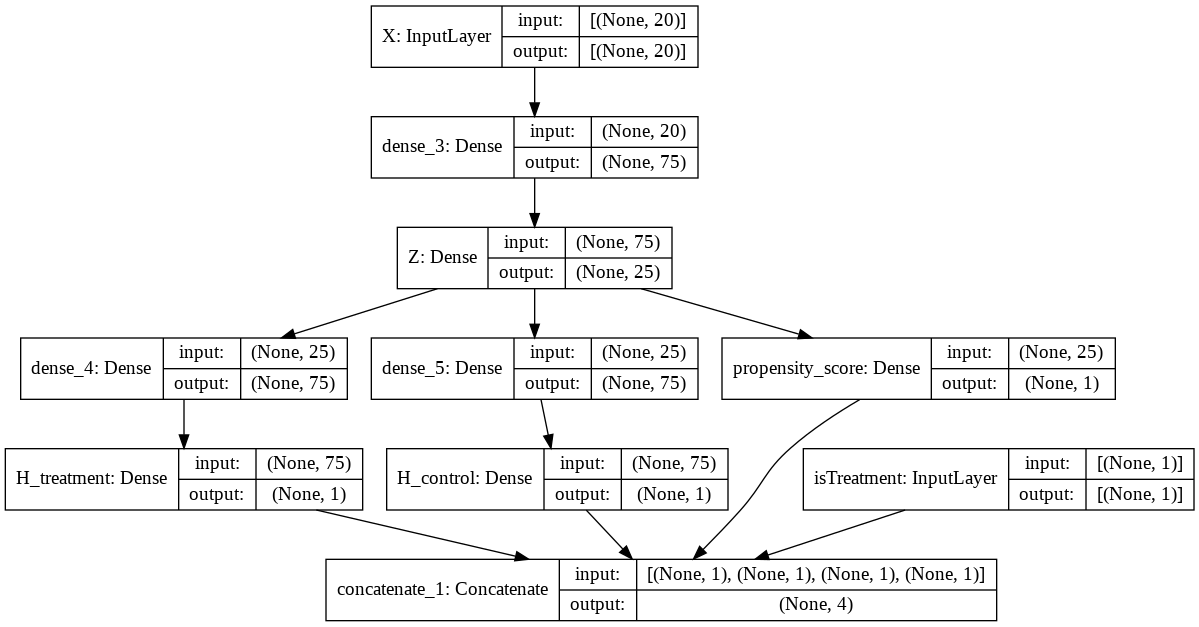

ITE Model


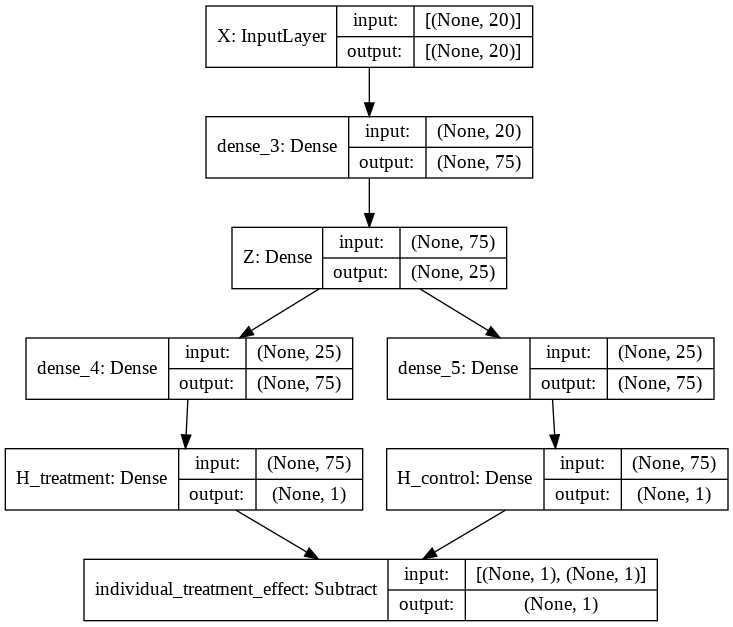

In [10]:
for model_i in [cmodel.trainable_model, cmodel.treatment_effect_model]:
    print(model_i.name)
    k.utils.plot_model(model_i, show_shapes=True)
    display(Image('model.png'))

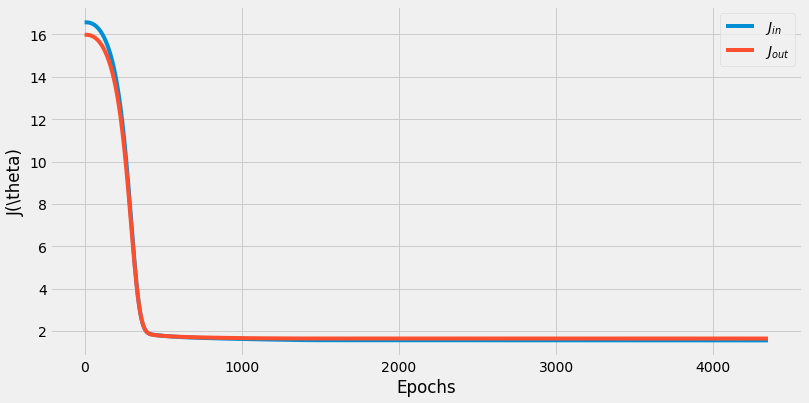

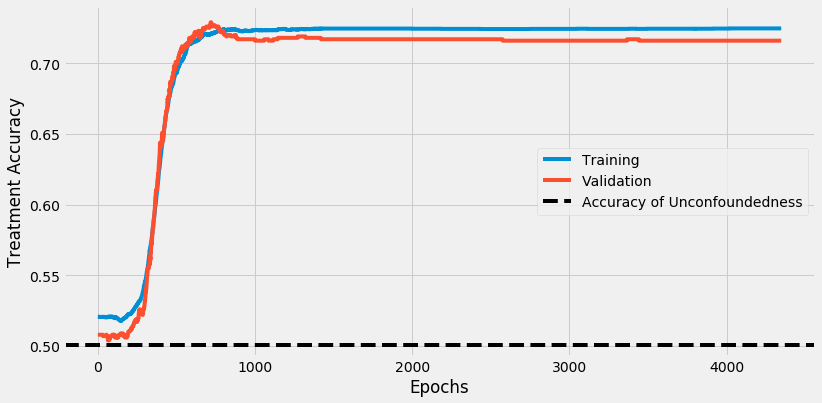

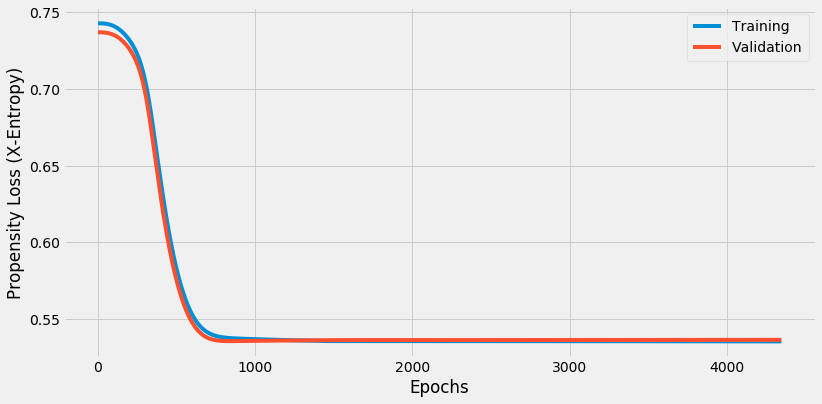

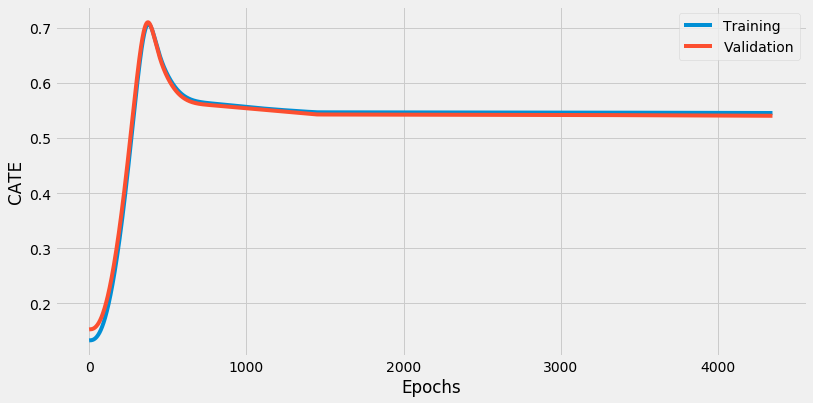

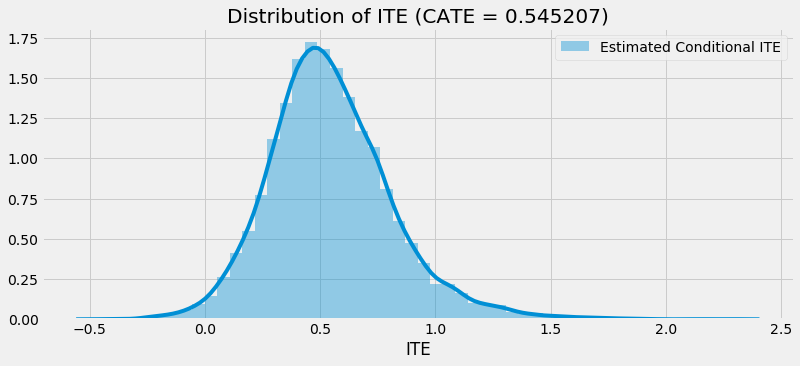

In [11]:
cmodel.plot_performance()

cmodel.plot_cate()

graph.figure(figsize=(12, 5))
graph.title(f'Distribution of ITE (CATE = {cmodel.compute_cate(x):2f})')
sns.distplot(cmodel.treatment_effect_model.predict(x), label='Estimated Conditional ITE')
graph.xlabel('ITE')
graph.legend()
graph.show()